In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AutoTokenizer
from torch import nn
import torch
from torch.optim import Adam
from tqdm import tqdm
import nltk
from nltk.tokenize import sent_tokenize
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')  # Download the Punkt tokenizer for sentence splitting


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
dataset = pd.read_csv('/content/BBC News Train.csv')

In [43]:
dataset.head()
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

<Axes: xlabel='Category'>

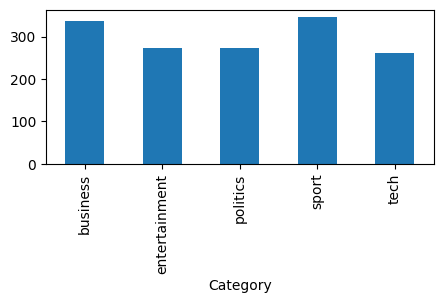

In [44]:
dataset.groupby(['Category']).size().plot.bar(figsize = (5, 2))

In [45]:
class BBC_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, target):

        self.labels = [labels[label] for label in target]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [46]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.softmax = nn.Softmax()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.softmax(linear_output)

        return final_layer

In [47]:
x_train, x_test, y_train, y_test = train_test_split(dataset['Text'], dataset['Category'], test_size=0.2, random_state=42)

In [48]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [49]:
x_train, x_val, x_test = BBC_Dataset(x_train, y_train), BBC_Dataset(x_val, y_val), BBC_Dataset(x_test, y_test)
train_dataloader = torch.utils.data.DataLoader(x_train, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(x_val, batch_size=2)
test_dataloader = torch.utils.data.DataLoader(x_test, batch_size=2)

In [50]:
epochs = 10
model = BertClassifier()
learning_rate = 1e-6

In [51]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate,  weight_decay=1e-5)

if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

train_loss = []
val_loss = []
for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item() - 1
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # now we evaluate on the validation data
        train_loss.append(total_loss_train)
        total_acc_val = 0
        total_loss_val = 0
        print(total_acc_train)
        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item() - 1
                total_acc_val += acc
        val_loss.append(total_loss_val)
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataloader): .3f} \
            | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} \
            | Val Loss: {total_loss_val / len(val_dataloader): .3f} \
            | Val Accuracy: {total_acc_val / len(val_dataloader): .3f}')

  0%|          | 0/477 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 477/477 [01:45<00:00,  4.50it/s]


-196
Epochs: 1 | Train Loss:  1.586             | Train Accuracy: -0.411             | Val Loss:  1.541             | Val Accuracy: -0.100


100%|██████████| 477/477 [01:45<00:00,  4.50it/s]


98
Epochs: 2 | Train Loss:  1.467             | Train Accuracy:  0.205             | Val Loss:  1.349             | Val Accuracy:  0.583


100%|██████████| 477/477 [01:45<00:00,  4.50it/s]


371
Epochs: 3 | Train Loss:  1.233             | Train Accuracy:  0.778             | Val Loss:  1.133             | Val Accuracy:  0.883


100%|██████████| 477/477 [01:45<00:00,  4.51it/s]


446
Epochs: 4 | Train Loss:  1.084             | Train Accuracy:  0.935             | Val Loss:  1.032             | Val Accuracy:  0.967


100%|██████████| 477/477 [01:45<00:00,  4.50it/s]


461
Epochs: 5 | Train Loss:  1.007             | Train Accuracy:  0.966             | Val Loss:  0.982             | Val Accuracy:  0.983


100%|██████████| 477/477 [01:45<00:00,  4.51it/s]


464
Epochs: 6 | Train Loss:  0.969             | Train Accuracy:  0.973             | Val Loss:  0.954             | Val Accuracy:  0.992


100%|██████████| 477/477 [01:45<00:00,  4.52it/s]


467
Epochs: 7 | Train Loss:  0.947             | Train Accuracy:  0.979             | Val Loss:  0.939             | Val Accuracy:  0.992


100%|██████████| 477/477 [01:45<00:00,  4.51it/s]


471
Epochs: 8 | Train Loss:  0.932             | Train Accuracy:  0.987             | Val Loss:  0.931             | Val Accuracy:  0.992


100%|██████████| 477/477 [01:45<00:00,  4.51it/s]


472
Epochs: 9 | Train Loss:  0.926             | Train Accuracy:  0.990             | Val Loss:  0.927             | Val Accuracy:  0.983


100%|██████████| 477/477 [01:45<00:00,  4.50it/s]


473
Epochs: 10 | Train Loss:  0.921             | Train Accuracy:  0.992             | Val Loss:  0.922             | Val Accuracy:  0.983


<function matplotlib.pyplot.show(close=None, block=None)>

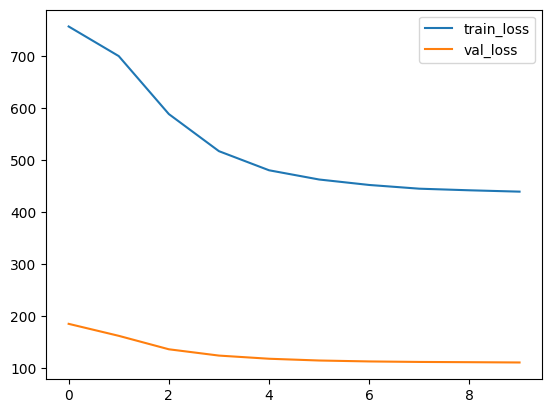

In [52]:
from matplotlib import pyplot as plt
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.show

In [53]:
test_acc = 0
total_loss_test=0

In [54]:
for val_input, val_label in test_dataloader:

    val_label = val_label.to(device)
    mask = val_input['attention_mask'].to(device)
    input_id = val_input['input_ids'].squeeze(1).to(device)

    output = model(input_id, mask)

    batch_loss = criterion(output, val_label)
    total_loss_test += batch_loss.item()

    acc = (output.argmax(dim=1) == val_label).sum().item() - 1
    test_acc += acc

In [55]:
test_acc/len(test_dataloader)

0.9731543624161074